In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost
import pickle


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# diabetes_data = pd.read_csv('/content/drive/MyDrive/Data_for_life_science_Diabetes_Prediction/diabetes.csv')
diabetes_data = pd.read_csv('diabetes.csv')

In [6]:
# Check for missing values
missing_values = diabetes_data.isnull().sum()

In [7]:
display(diabetes_data.info(),diabetes_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


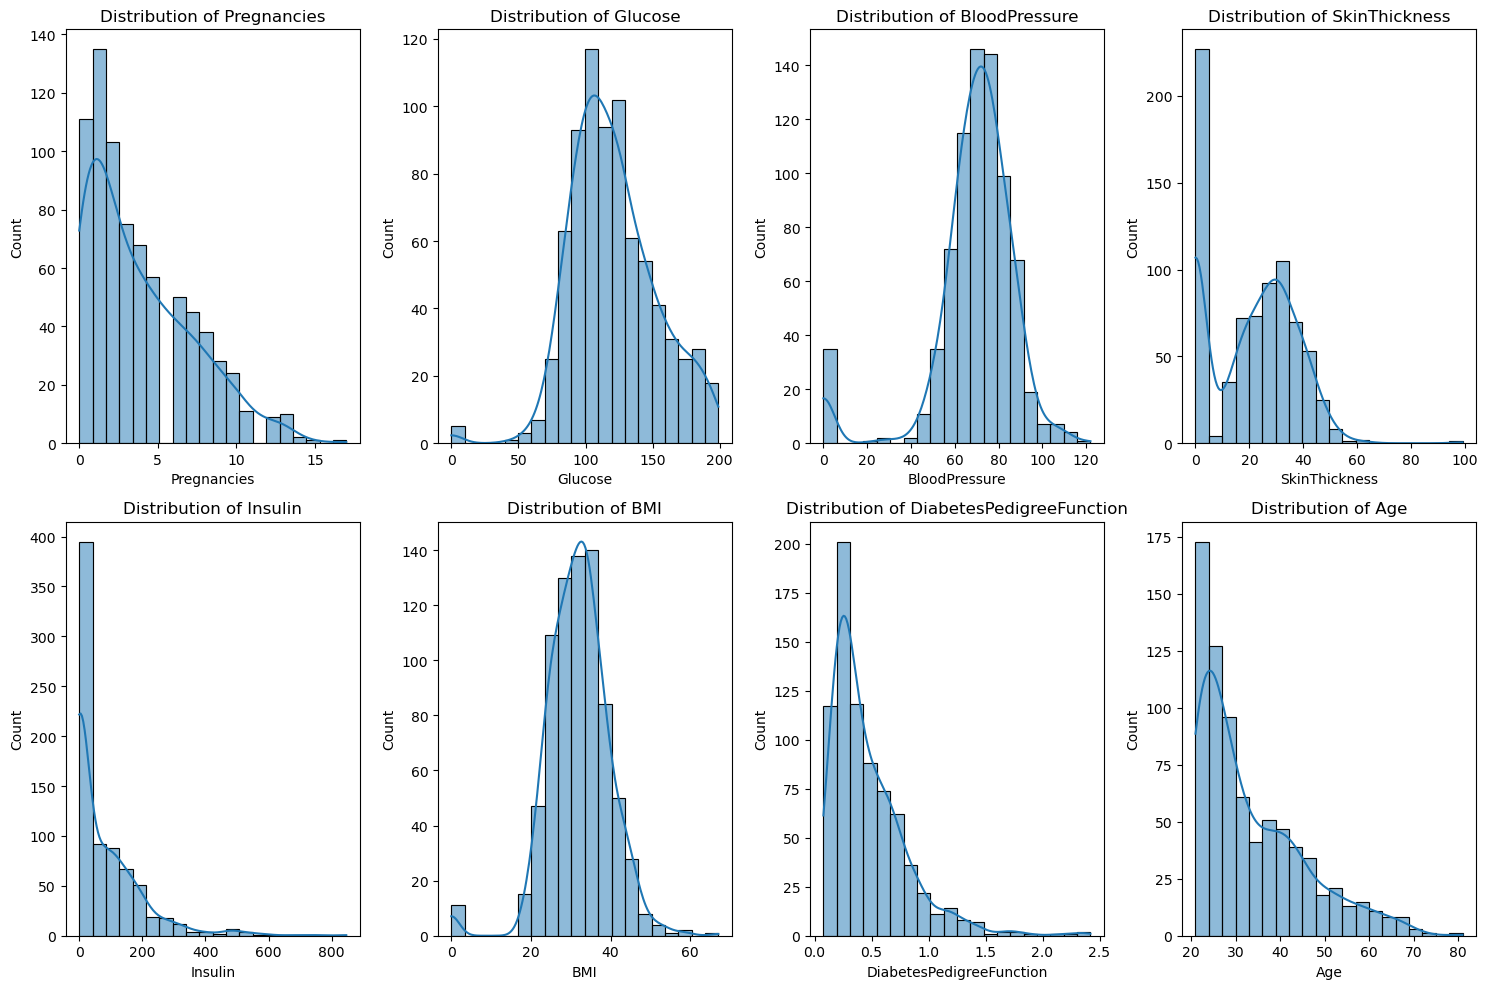

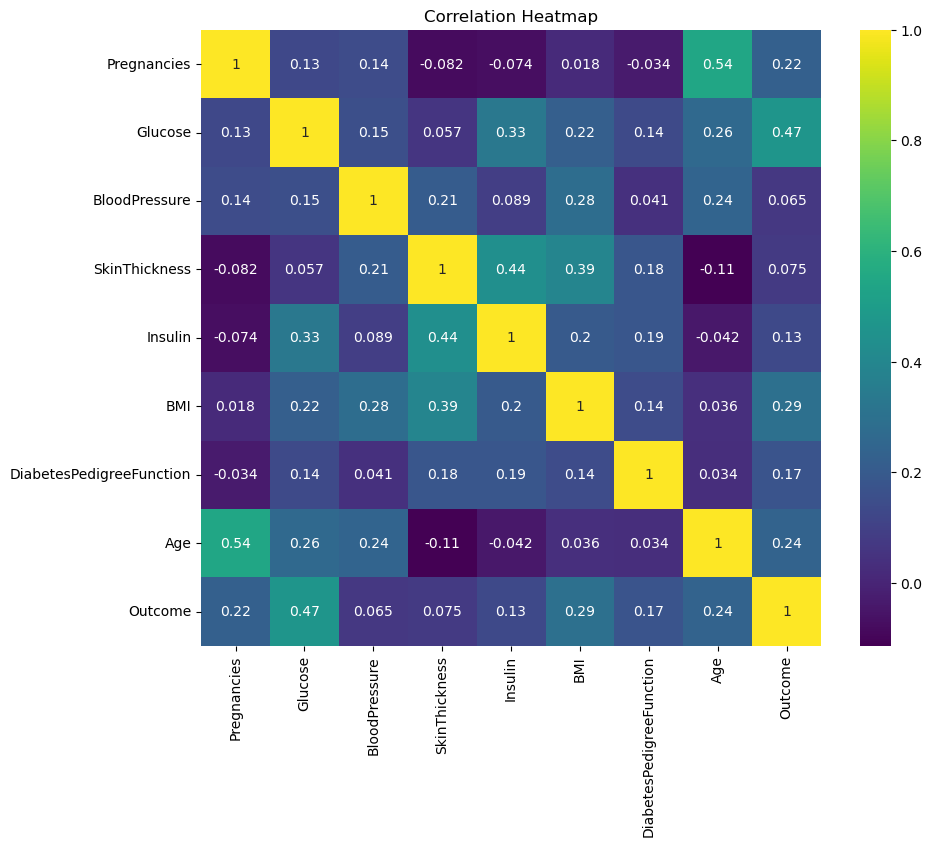

In [8]:
plt.figure(figsize=(15, 10))

# Subplots for each key variable
variables = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, var in enumerate(variables, 1):
    plt.subplot(2, 4, i)
    sns.histplot(diabetes_data[var], kde=True, bins=20)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_data.corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()



In [9]:
import plotly.graph_objs as go
import plotly.offline as py
# 2 datasets
D = diabetes_data[(diabetes_data['Outcome'] != 0)]
H = diabetes_data[(diabetes_data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = diabetes_data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=diabetes_data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = diabetes_data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [10]:
target_count()
target_percent()

In [11]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    
missing_plot(diabetes_data, 'Outcome')

Over sampling

In [54]:
from imblearn.over_sampling import SMOTE

X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

diabetes_data = pd.DataFrame(X_resampled, columns=X.columns)
diabetes_data['Outcome'] = y_resampled

# Machine Learning models

In [55]:
# Load the dataset
df_ml = diabetes_data.copy()

# Preprocessing
X = df_ml.drop('Outcome', axis=1)
y = df_ml['Outcome']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers with modified parameters
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=42),
    "Logistic Regression": LogisticRegression(C=1.0, solver='lbfgs', random_state=42),
    "Support Vector Machine": SVC(C=1.0, kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Training and evaluating each model
best_model, best_score = None, 0
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} Accuracy: {accuracy}")
    if accuracy > best_score:
        best_model = clf
        best_score = accuracy

# Best model
print("Best Model:", best_model)


Random Forest Accuracy: 0.83
Gradient Boosting Accuracy: 0.855
AdaBoost Accuracy: 0.78
Logistic Regression Accuracy: 0.755
Support Vector Machine Accuracy: 0.755
K-Nearest Neighbors Accuracy: 0.77
Best Model: GradientBoostingClassifier(max_depth=5, random_state=42)


In [61]:
# Define the parameter grid for Grid Search
param_grid = {'learning_rate' : [0.01, 0.02, 0.03],
              'n_estimators' : [100, 500, 1000,2000 ],
              'max_depth': [1, 3, 5]}


gb_classifier = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_

best_gb_predictions = best_gb_model.predict(X_test)
best_gb_accuracy = accuracy_score(y_test, best_gb_predictions)


print("Best Parameters:", best_params)
print("Best Gradient Boosting Accuracy:", best_gb_accuracy)


Best Parameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 2000}
Best Gradient Boosting Accuracy: 0.8


In [62]:
import joblib
joblib.dump(best_gb_model, 'best_gb_model.pkl')

['best_gb_model.pkl']

In [63]:
from sklearn.metrics import accuracy_score, classification_report


loaded_model = joblib.load('best_gb_model.pkl')

y_test_pred = loaded_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate a classification report
class_report = classification_report(y_test, y_test_pred)
print('Classification Report:')
print(class_report)


Test Accuracy: 0.8000
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        99
           1       0.77      0.86      0.81       101

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



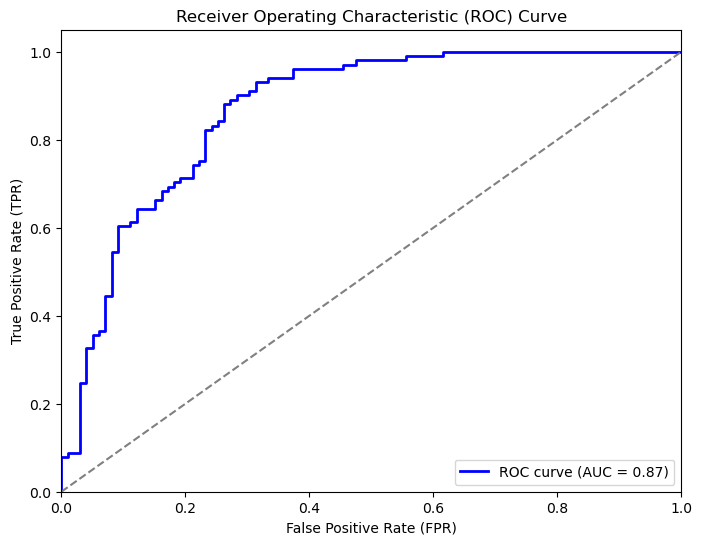

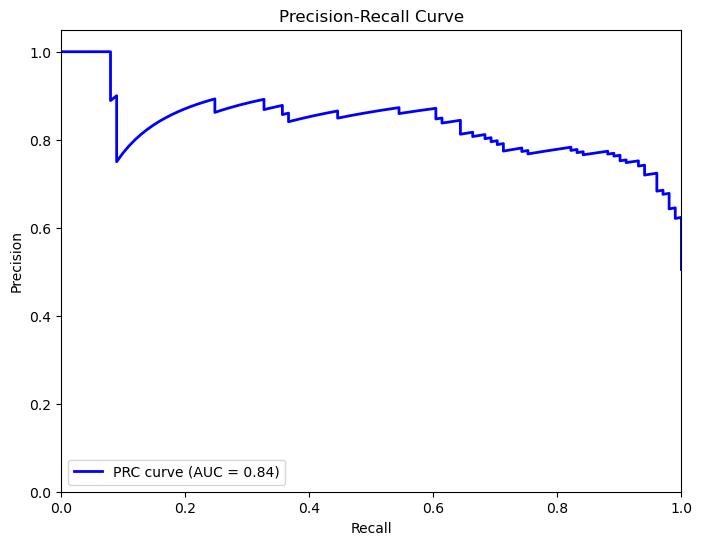

In [64]:

# Load the saved model from the file
loaded_model = joblib.load('best_gb_model.pkl')

# Make predictions on a test dataset (replace X_test with your test data)
y_test_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Calculate precision-recall curve and AUC
precision, recall, thresholds_prc = precision_recall_curve(y_test, y_test_pred_proba)
prc_auc = average_precision_score(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC curve (AUC = {prc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import warnings

# Suppress the UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

import joblib
import pickle
# Best parameters from hyperparameter tuning (replace these with your actual best parameters)
best_params_rf = {'n_estimators': 100, 'max_depth': 100}  # Example parameters
best_params_gb = {'n_estimators': 100, 'learning_rate': 0.02}  # Example parameters


# Initialize the models with the best parameters
log_reg = LogisticRegression(C=10, solver='newton-cg', max_iter=1000)
log_reg.fit(X_train, y_train)
random_forest = RandomForestClassifier(**best_params_rf)
gradient_boosting = GradientBoostingClassifier(**best_params_gb)

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', random_forest), ('gb', gradient_boosting)],
    voting='soft'
)

# Train the ensemble classifier
voting_clf.fit(X_train, y_train)

# Evaluate the model
predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
with open('logistic_reg.pkl', 'wb') as model_file:
    pickle.dump(voting_clf.fit(X_train, y_train), model_file)
print("Accuracy of Ensemble Model:", accuracy)
print("Classification Report:\n", report)


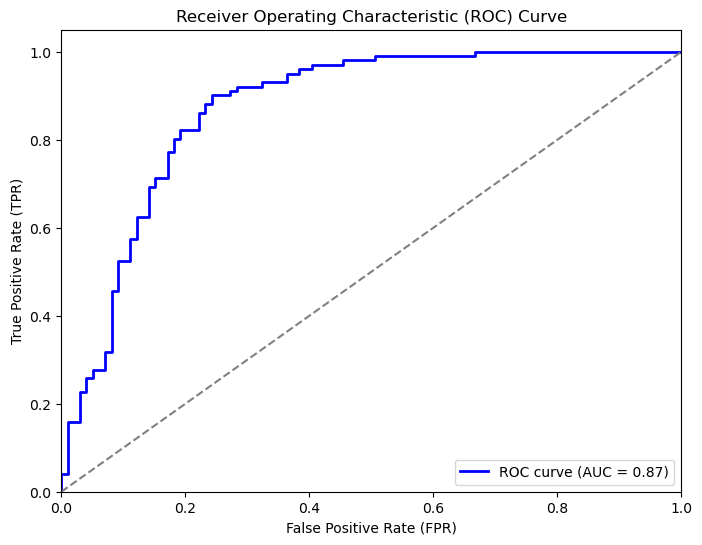

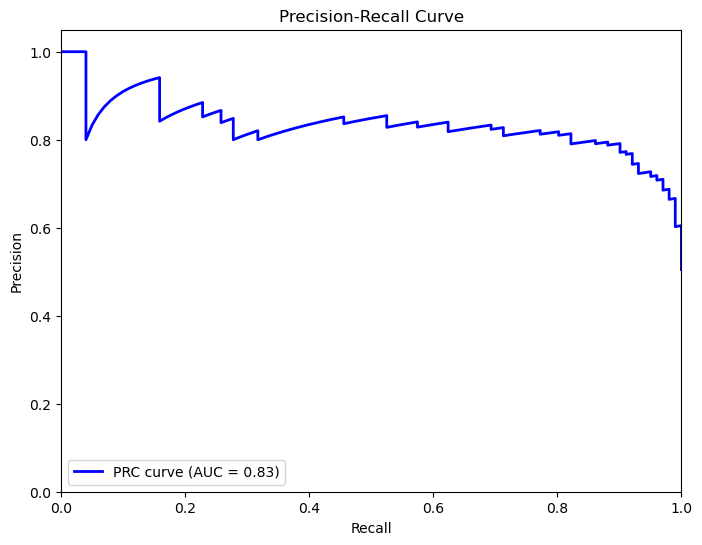

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Load the saved model from the file
loaded_model = joblib.load('logistic_reg.pkl')

# Make predictions on a test dataset (replace X_test with your test data)
y_test_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Calculate precision-recall curve and AUC
precision, recall, thresholds_prc = precision_recall_curve(y_test, y_test_pred_proba)
prc_auc = average_precision_score(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC curve (AUC = {prc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [67]:
# Check current shape
print("Current shape of X_train:", X_train.shape)

# Reshape (assuming you want to treat each feature as a separate time step)
# This reshapes X_train to [samples, features, 1]
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("New shape of X_train:", X_train_reshaped.shape)

# Now use X_train_reshaped in place of X_train for LSTM
input_dim = X_train_reshaped.shape[2]  # This should now work without error


Current shape of X_train: (800, 8)
New shape of X_train: (800, 8, 1)


In [ ]:
df_my = diabetes_data.copy()
X = df_my.iloc[:, :-1].values
y = df_my.iloc[:, -1].values
y = pd.get_dummies(y)
norm = StandardScaler()
X    = norm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize the XGBoost model and perform hyperparameter tuning
xgboost = xgboost.XGBClassifier(
    gamma=0.1,
    eta=0.001,
    n_estimators=50
)

param_gs_xgboost = [{'gamma':[0.1, 0.2, 0.3],
                     'eta':[1e-3, 1e-2],
                     'n_estimators':[50, 100]
                    }]

gs_xgboost = GridSearchCV(estimator=xgboost,
                          param_grid=param_gs_xgboost,
                          scoring='accuracy',
                          cv=3)

gs_XGBoost = gs_xgboost.fit(X_train, y_train)

# Save the XGBoost model
xgboost_model = gs_XGBoost.best_estimator_
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(xgboost_model, model_file)

# Define your PyTorch neural network model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(8, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 30)
        self.fc4 = nn.Linear(30, 20)
        self.fc5 = nn.Linear(20, 17)
        self.fc6 = nn.Linear(17, 15)
        self.fc7 = nn.Linear(15, 10)
        self.fc8 = nn.Linear(10, 15)
        self.fc9 = nn.Linear(15, 8)
        self.fc10 = nn.Linear(8, 4)
        self.fc11 = nn.Linear(4, 2)
        self.relu = nn.ELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.relu(self.fc10(x))
        x = self.fc11(x)
        return x

# Create an instance of your PyTorch model and move it to the GPU
model = MyModel().to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Convert your data to PyTorch tensors and move them to the GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(np.argmax(y_train.values, axis=1)).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(np.argmax(y_test.values, axis=1)).to(device)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Training loop for the PyTorch model
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

# Evaluate the PyTorch model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test data (PyTorch model): {accuracy}%')


# LSTM - RNN model: 

Parameters
input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional LSTM. Default: False

proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0

In [ ]:
# Load and preprocess your diabetes dataset
df_my = diabetes_data.copy()
X = df_my.iloc[:, :-1].values
y = df_my.iloc[:, -1].values
y = pd.get_dummies(y)
norm = StandardScaler()
X = norm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Further split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val.values)

# Define a more complex RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1, num_layers=3, dropout_rate=0.5):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        x = self.bn1(lstm_out[:, -1])
        predictions = self.linear(x)
        return predictions
# Define hyperparameters for the more complex model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
sequence_length = 1

hyperparameters = {
    'hidden_size': [64, 128, 256],
    'num_layers': [2, 4, 6],
    'learning_rate': [0.01, 0.02, 0.05],
    'num_epochs': [50, 100]
}

# Initialize best validation loss to infinity
best_val_loss = float('inf')

# You can iterate over the hyperparameters for grid search or random search
for hidden_size in hyperparameters['hidden_size']:
    for num_layers in hyperparameters['num_layers']:
        for learning_rate in hyperparameters['learning_rate']:
            for num_epochs in hyperparameters['num_epochs']:
                # Convert data to PyTorch tensors
                X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)
                y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)

                # Create the more complex RNN model
                model = RNN(input_size, hidden_size, output_size, num_layers)

                # Loss and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(num_epochs):
                    # Train for one epoch
                    model.train()
                    outputs = model(X_train_tensor)
                    optimizer.zero_grad()
                    loss = criterion(outputs, y_train_tensor)
                    loss.backward()
                    optimizer.step()

                    # Evaluate on validation set
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor.unsqueeze(1))
                        val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))

                    # If this model is better, save it
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        torch.save(model.state_dict(), 'best_model.pth')

                    # Print progress
                    if (epoch + 1) % 10 == 0:
                        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Test the best model
with torch.no_grad():
    test_input = torch.FloatTensor(X_test).unsqueeze(1)
    predicted_output = model(test_input)
    print("Predicted Output Shape:", predicted_output.shape)


In [70]:
model.eval()

ComplexRNN(
  (lstm): LSTM(8, 128, num_layers=6, dropout=0.5)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [72]:
from torchviz import make_dot
from sklearn.metrics import accuracy_score


sequence_length = 1
input_size = 8
output_size = 1

# Plot the model
x = torch.randn(1, sequence_length, input_size)
output = model(x)
dot = make_dot(output)
dot.render('model_graph')

'model_graph.pdf'

In [73]:
# Load and preprocess your diabetes dataset
df_my = diabetes_data.copy()
X = df_my.iloc[:, :-1].values
y = df_my.iloc[:, -1].values
y = pd.get_dummies(y)
norm = StandardScaler()
X = norm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Convert your validation data to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val).view(-1, sequence_length, input_size)
y_val_tensor = torch.LongTensor(np.argmax(y_val.values, axis=1))  # Convert one-hot encoded labels to class labels

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    # Make predictions on the validation set
    y_pred = model(X_val_tensor)

# Use softmax to obtain class probabilities
softmax = torch.nn.Softmax(dim=1)
y_pred_probs = softmax(y_pred)

# Convert the predictions to class labels
y_pred_labels = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = accuracy_score(y_val_tensor.numpy(), y_pred_labels.numpy())
print(f'Accuracy: {accuracy}')


Accuracy: 0.4714285714285714
